In [127]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import scipy as sp

from scipy import signal
from scipy import io

from neurodsp import spectral

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Here we're just going to start by simulating sine waves and looking at the FFT of those

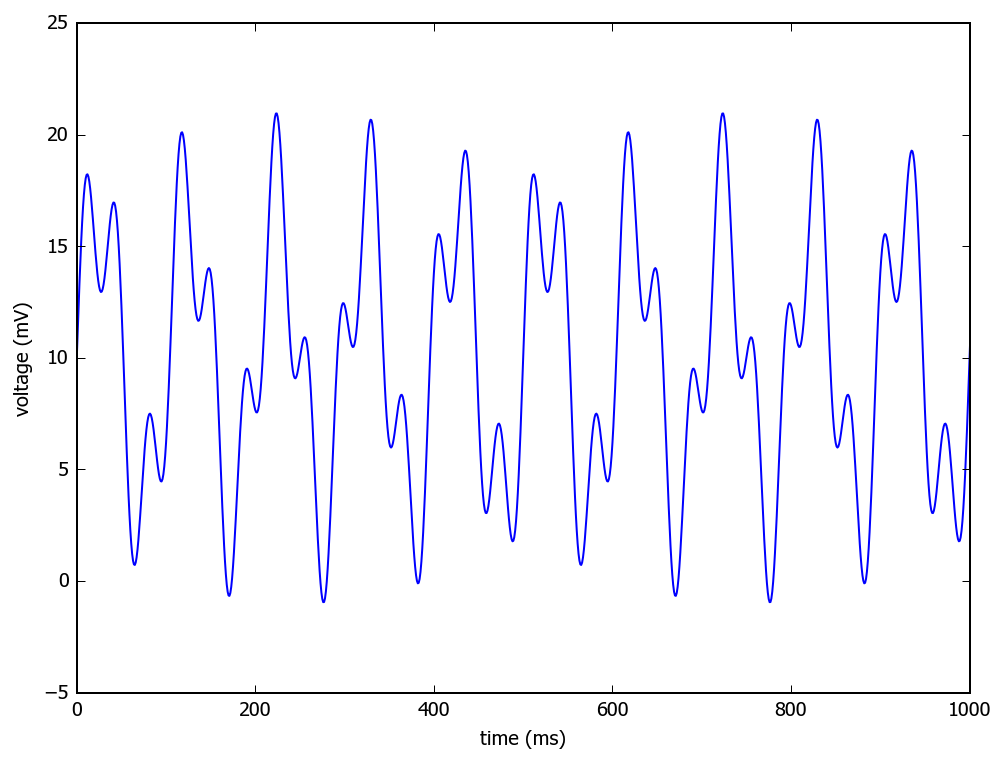

In [128]:
# define a function to create a sine wave
def sine_func(fs, freq, amp, time):
    samples = fs*time
    time = np.arange(samples)
    voltage = amp * np.sin(2 * np.pi * freq * time / fs)
    
    return time, voltage

fs = 1000 # sampling rate

freq = 10 # in Hz
amp = 7 # in arbitrary units (au)
duration = 10. # in seconds

time, sine = sine_func(fs, freq, amp, duration)
sine = sine + 10 # add a DC offset

# add another sine to the first
freq, amp, duration = 28, 4, 10.
_, sine = sine + sine_func(fs, freq, amp, duration)

# plot some of the time series data
plt.plot(time, sine)
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')
plt.xlim((0,1000)) # just plot the first second
plt.show()

### Check out the funky patterns that start to emerge from just _two_ sine waves overlapped!

### Let's look at the pwoer spectrum now

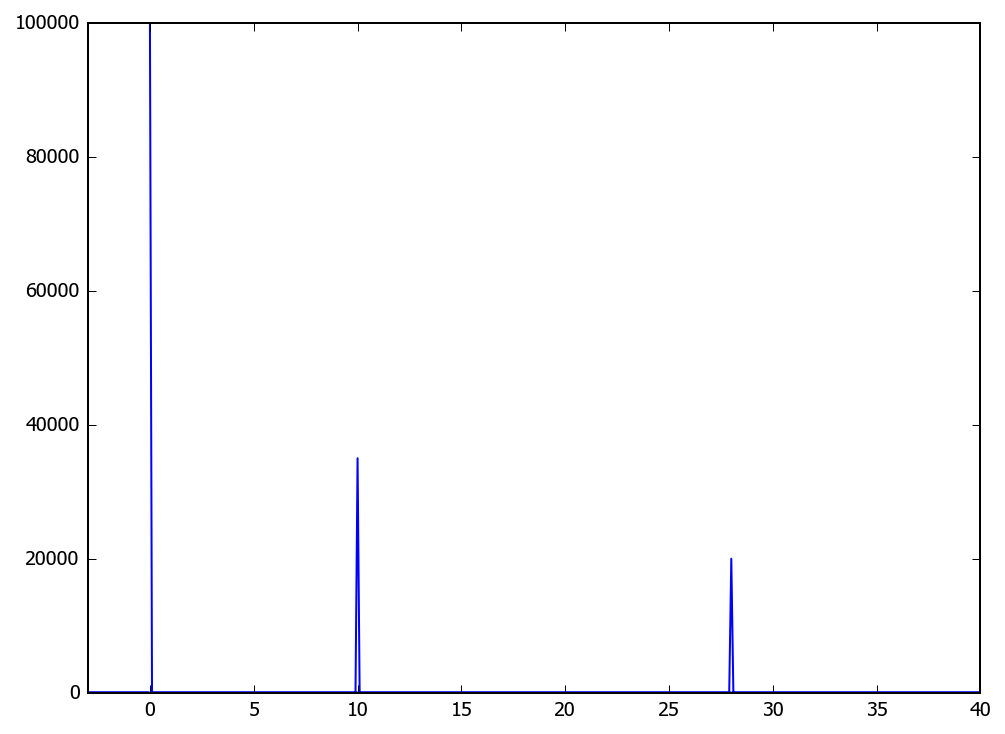

In [129]:
sp = np.abs(np.fft.fft(sine)) # get the power spectrum of the simulated data
freq = np.fft.fftfreq(sine.shape[-1])*fs # get the frequencies from the FFT

# plot the spectrum
plt.plot(freq, sp)
plt.xlim((-3, 40))
plt.show()

### We see a lot of power at 0 Hz, which equals the DC offset we added. We also see power at both 10 and 28 Hz, which is good, because that's all our signal is!

### Now we'll add more sine waves and see what happens.

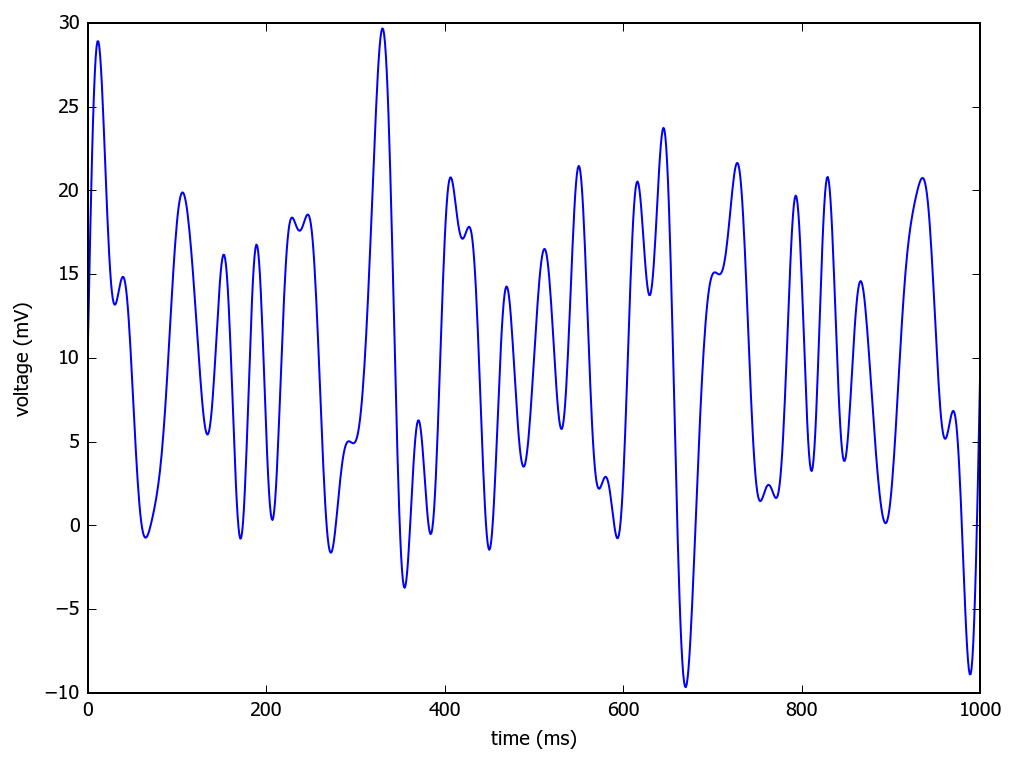

In [130]:
## add some more sine waves!
freq, amp, duration = 13, 6, 10.
_, sine = sine + sine_func(fs, freq, amp, duration)
freq, amp, duration = 22, 4.5, 10.
_, sine = sine + sine_func(fs, freq, amp, duration)
freq, amp, duration = 33, 2, 10.
_, sine = sine + sine_func(fs, freq, amp, duration)

# plot some of the time series data
plt.plot(time, sine)
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')
plt.xlim((0,1000)) # just plot the first second
plt.show()

### Now it starts to look pretty wild! Pretty "complex" looking, but from the FFT we'll see it's still pretty "simple".

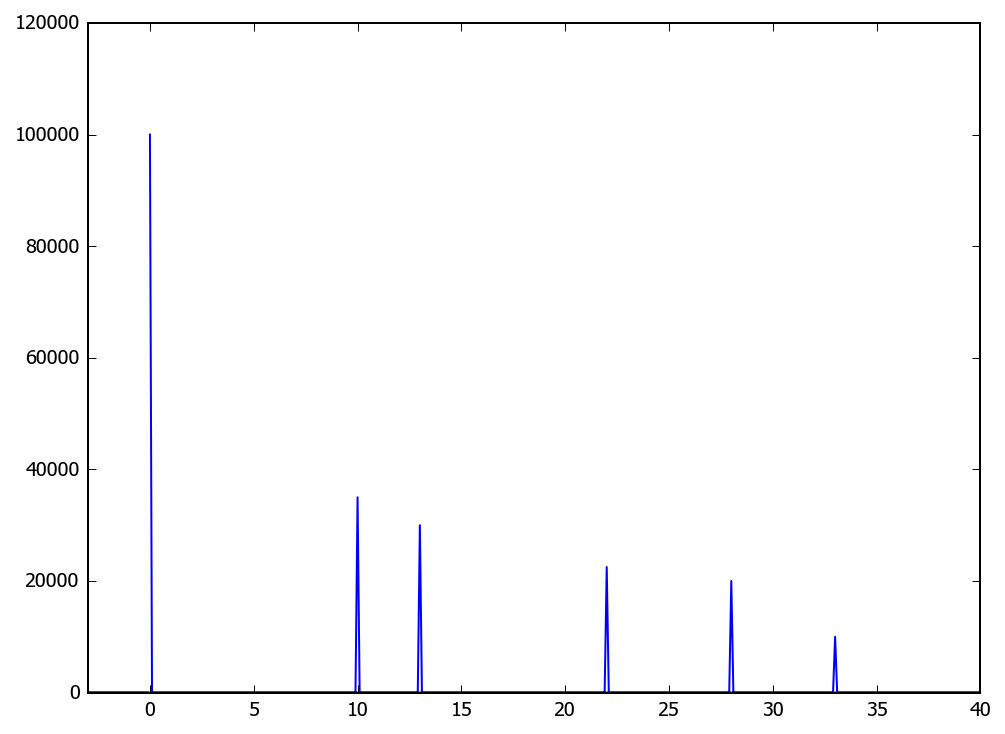

In [131]:
sp = np.abs(np.fft.fft(sine)) # get the power spectrum of the simulated data
freq = np.fft.fftfreq(sine.shape[-1])*fs # get the frequencies from the FFT

# plot the spectrum
plt.plot(freq, sp)
plt.xlim((-3, 40))
plt.show()

### There's only power in the exact frequencies we added.

## Now we're going to actually load in real neural data and play with that

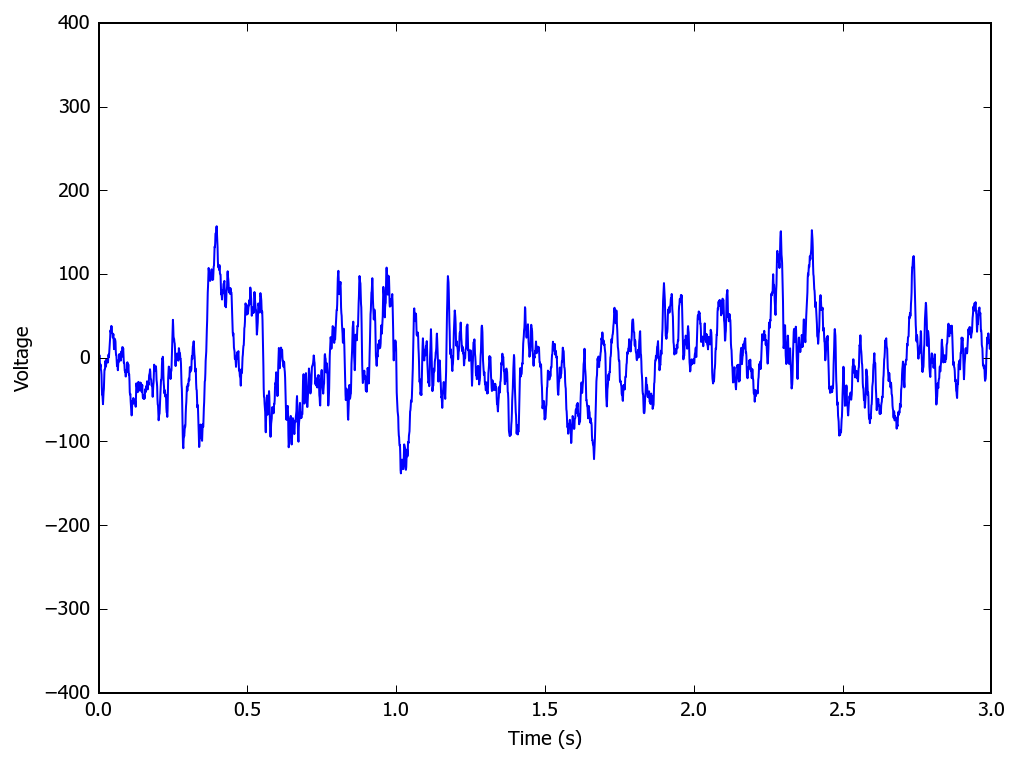

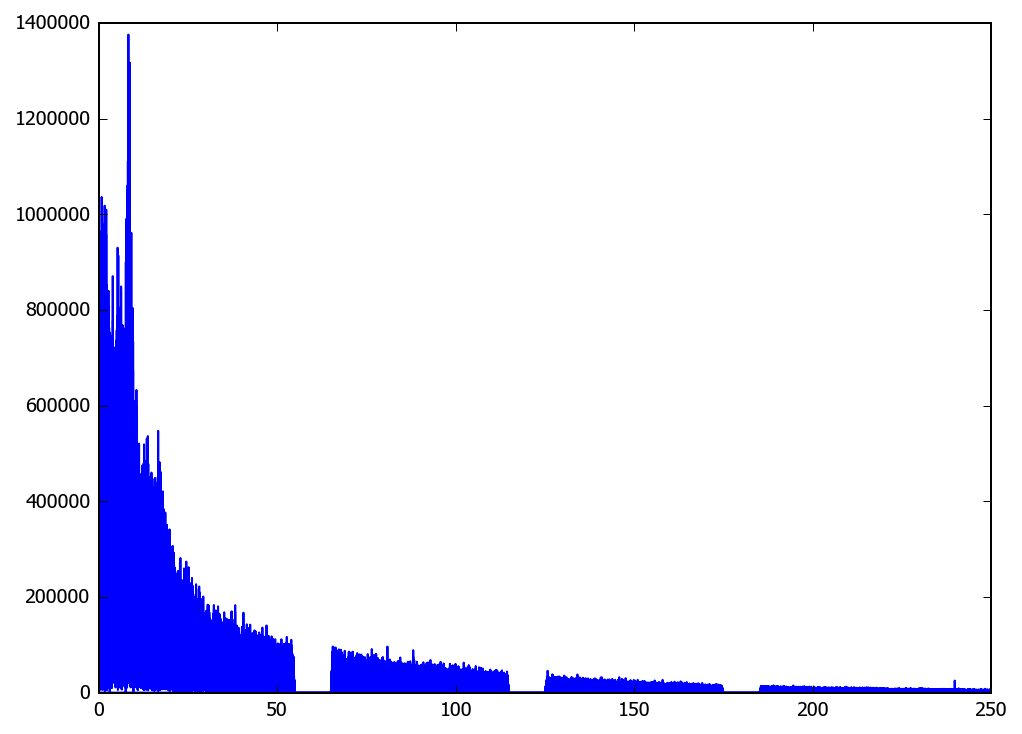

In [132]:
fs = 1000 # this is the sampling rate of the data, in HZ

# load the visual cortical ECOG channel, and the event indicces
data = io.loadmat('data/ecog_data.mat', squeeze_me=True)
sta = data['sta']
tar = data['tar']
resp = data['resp']
data = data['data']

# plot some of the data
t = np.arange(len(data))/fs
plt.plot(t, data)
plt.xlim((0,3))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

sp = np.abs(np.fft.fft(data)) # get the power spectrum of the ECoG data
freq = np.fft.fftfreq(data.shape[-1])*fs # get the frequencies from the FFT

# plot the spectrum
plt.plot(freq, sp)
plt.xlim((0, 250))
plt.show()


### This is a _very noise_ power spectrum, and hard to interpret.

### Also notice the "gaps" in the spectrum around 60, 120, and 180 Hz. This shows that a notch filter has been applied around the 60 Hz line noise, and its harmonics, to "zero out" the power in those frequencies.

### Because this is so noisy, and we don't need the super high-fidelity frequency resolution the real data has, we'll window our data, FFT each window, and average those FFTs together to get a lower frequency resolution, but "cleaner", power spectral density.

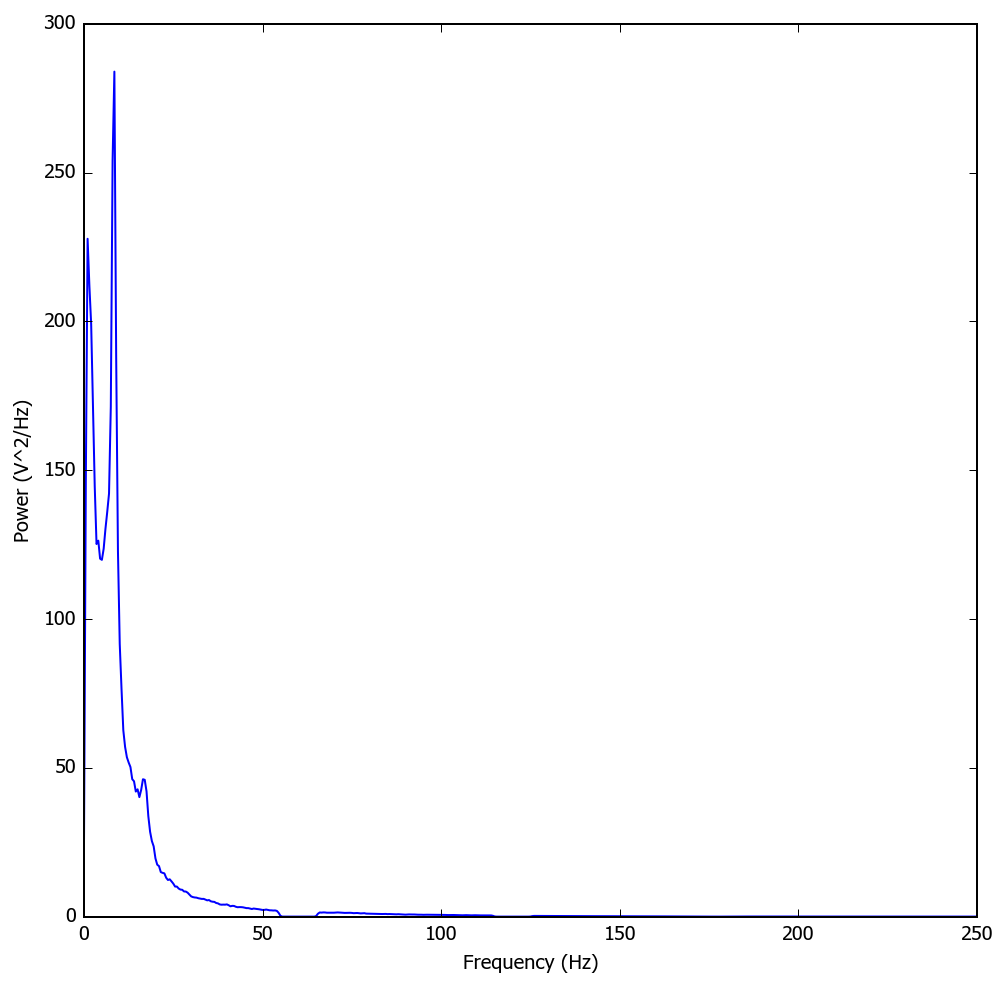

In [133]:
freq_mean, P_mean = spectral.psd(data, fs, method='mean', window='hann', nperseg=fs*2) # mean of spectrogram (Welch)
# This breaks the data up into two-second windows (nperseg=fs*2)
# It then applies a hanning window to the time-series windows (window='hann')
# It then FFTs each hanning'd window, and then averages all those FFTs (method='mean')

plt.figure(figsize=(8,8))
plt.plot(freq_mean, P_mean)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.xlim((0, 250))
plt.show()


### Here the "1/f" aspect of the data is clear: the lowest frequencies have _exponentially higher_ power than the highest frequencies. We can't even see the power above ~100 Hz.

### We can also see a _huge_ burst of power at around 10 Hz. This is a very clear, strong, alpha oscillation in the visual cortex. We also see a little bump of power at around 20 Hz. Later we'll explore to see if that a "real" ~20 Hz beta oscillation, or something else.

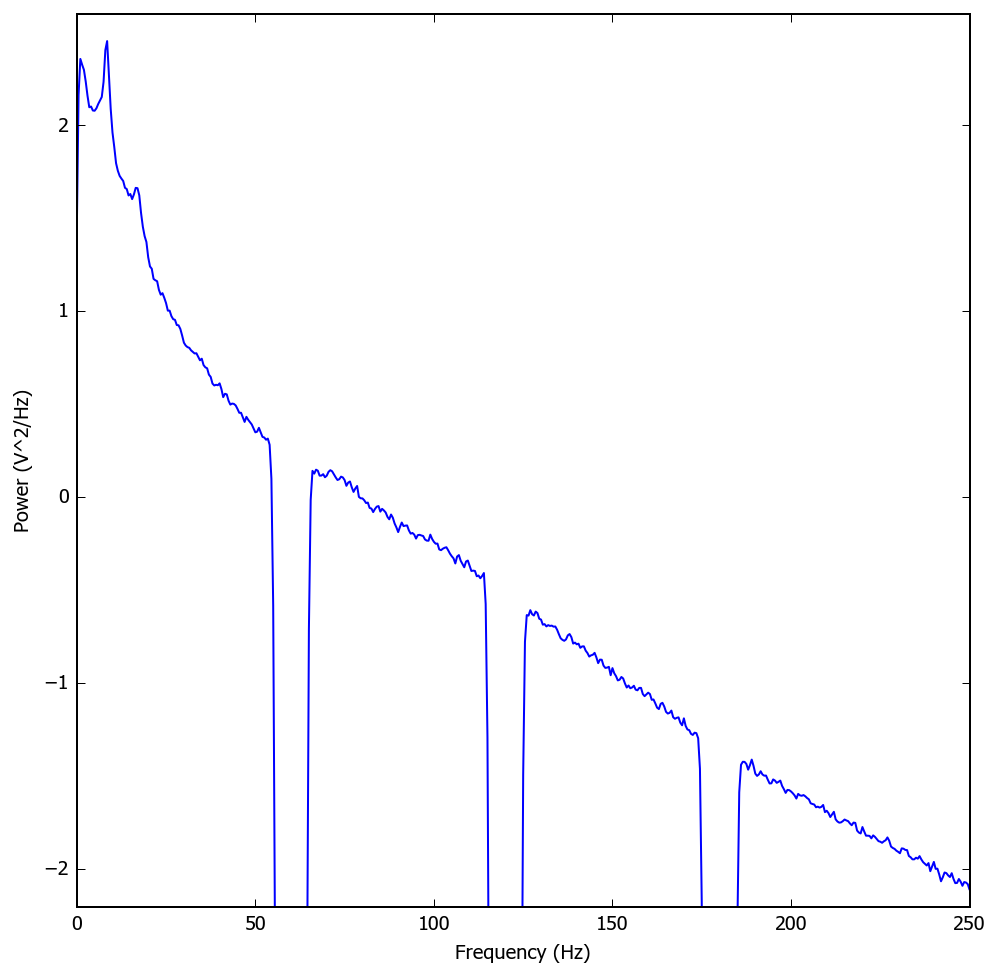

In [134]:
# plot again, but log scale the power

plt.figure(figsize=(8,8))
plt.plot(freq_mean, np.log10(P_mean))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.xlim((0, 250))
plt.ylim((-2.2, 2.6))
plt.show()

### Note that if we log-scale the power (y-axis) it starts to look like a straight line, except for the oscillatory bumps and the notch filters.

### Let's zoom in on just the < 60 Hz regions...

/Users/Voytek/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


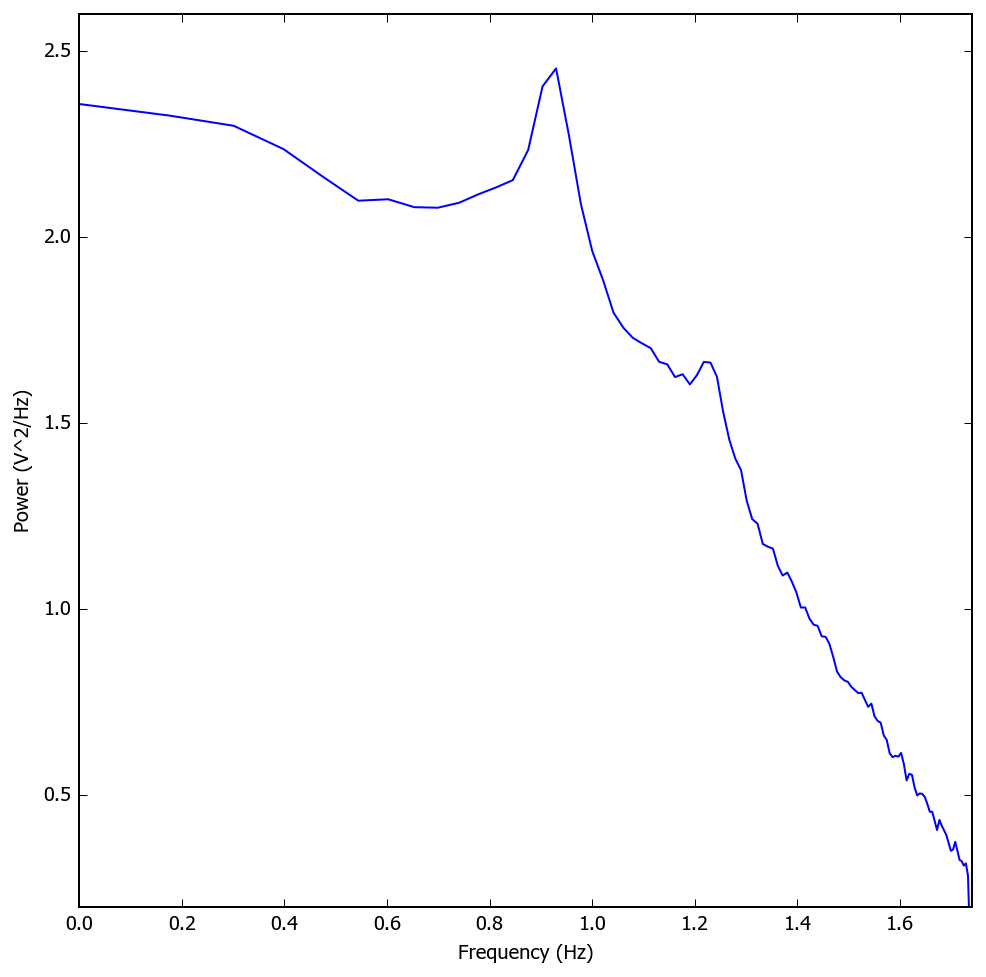

In [135]:
# plot again, but log scale the power, zoom in below 60 Hz, and log scale the frequency axis

plt.figure(figsize=(8,8))
plt.plot(np.log10(freq_mean), np.log10(P_mean))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.xlim((0, np.log10(55)))
plt.ylim((0.2, 2.6))
plt.show()

### Now that's a beautiful power spectrum!